In [1]:
import random
import os
from collections import defaultdict
import logging

import pandas as pd
import numpy as np
import matplotlib as mpl

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

from notebook_util import plot_v_function, evaluate_td_learning, plot_stat, plot_training_process, plot_final_stat
from rl_learning import SimplePolicy, FirstVisitMonetCarloSimulation, Sarsa, \
    BlackjackEnvDouble, ExtendedAction, BaseBlackjackEnv, BlackjackWithShuffle
from rl_learning.utils import get_seed

In [4]:
mpl.rcParams["figure.figsize"] = (20, 18)
mpl.rcParams["font.size"] = 10

# Часть первая

## Простая стратегия

С помощью first-visit метода Монте-Карло оценим сначала функцию $V(s)$ 

In [5]:
policy = SimplePolicy()
simulator = FirstVisitMonetCarloSimulation(BaseBlackjackEnv(natural=True, seed=get_seed()), policy)

In [6]:
rewards = simulator.simulate(500_000)

100%|██████████| 500000/500000 [00:53<00:00, 9412.29it/s] 


In [7]:
rows = []
for state, expected_reward in rewards.items():
    rows.append(state + (expected_reward,))

stat = pd.DataFrame(rows, columns=["player_sum", "dealer_open_card", "usable_ace", "reward"])
del rows

In [8]:
usable_ace_stat = stat[stat["usable_ace"] == True]
not_usable_ace_stat = stat[stat["usable_ace"] == False]

Далее представлена оценка функции $V(s)$ для случаев:
* Туз равен 11 очкам.
* Туз равен 1 очкам.

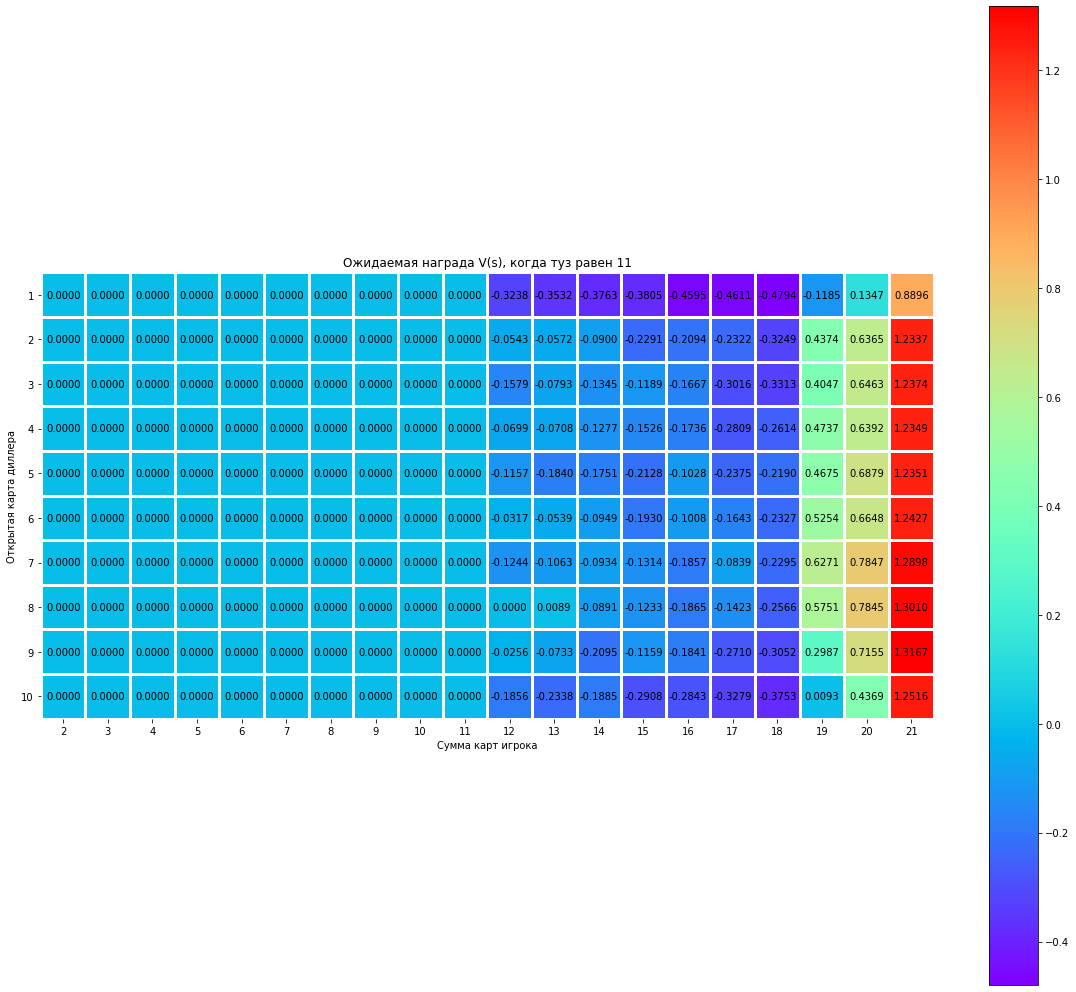

In [9]:
plot_v_function(usable_ace_stat, "Ожидаемая награда V(s), когда туз равен 11");

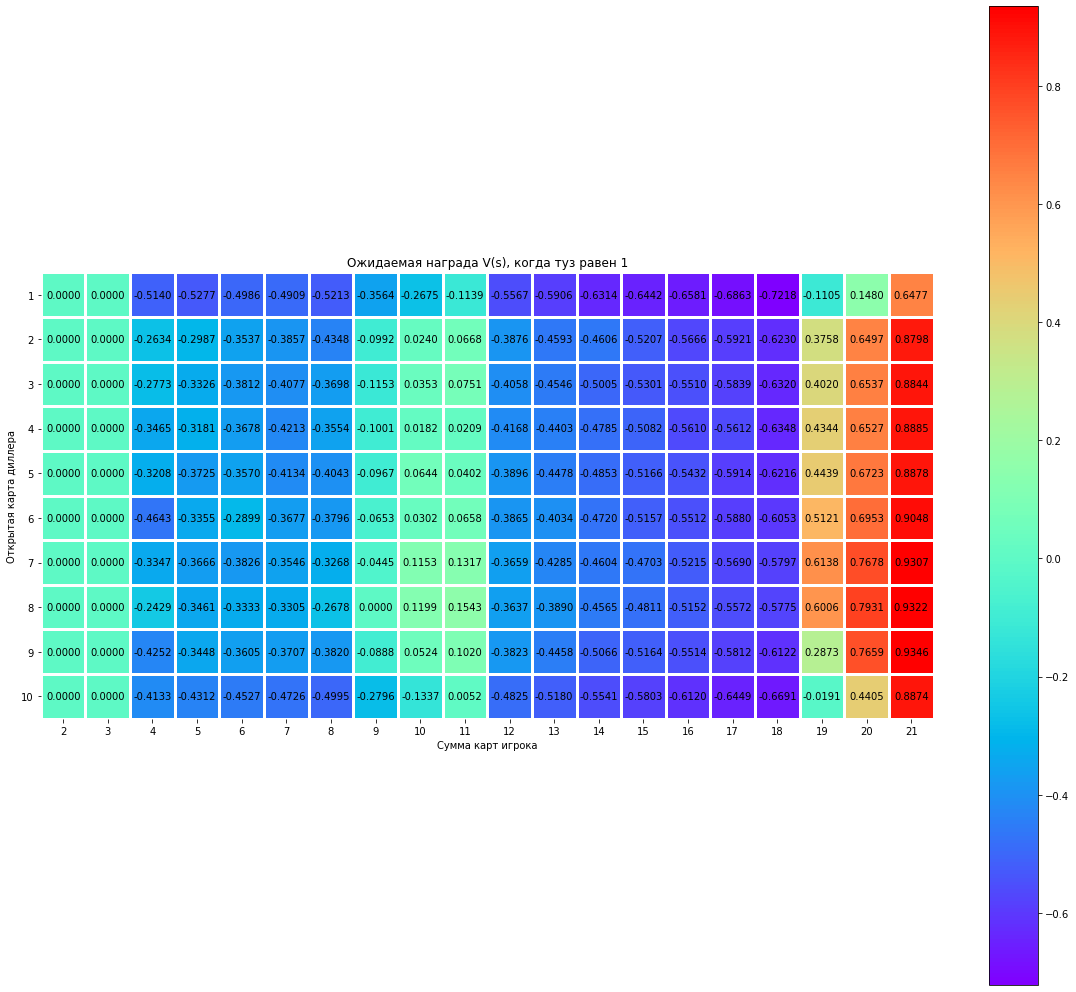

In [10]:
plot_v_function(not_usable_ace_stat, "Ожидаемая награда V(s), когда туз равен 1");

Далее представлены результаты обучения с помощью разных алгоритмов, разных параметров и для разных версий окружений.

Логика проверки алгоритмов была следующая:
1. Запускается тестовое обучение с разными параметрами.
2. На этих параметрах запускается симуляция без обучения и вычисляется средняя награда для выбора наилучших параметров.
3. Тренируется алгоритм с наилучшими параметрами, но увеличенным числом эпизодов.
4. Ещё раз запускается симуляция для оценки финального результата. При этом $\epsilon = 0$. Используется жадная стратегия.

## Q-обучение

In [11]:
gama_values = np.linspace(1e-3, 0.3, 4)
alpha_values = np.linspace(0.1, 0.3, 4)
num_train_episodes = 100_000
num_test_episodes = 30
num_train_episodes_on_best = 100_000
epsilon = 0.04

env = BaseBlackjackEnv(natural=True, seed=get_seed())
states = defaultdict(dict)

log_file = "logs.txt"
logging.shutdown()

if os.path.isfile(log_file):
    os.remove(log_file)

In [12]:
train_stat, test_stat, training_process, final_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values, epsilon=epsilon,
    num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes, env=env, num_train_episodes_on_best_params=num_train_episodes_on_best)
states["base"]["q"] = final_stat

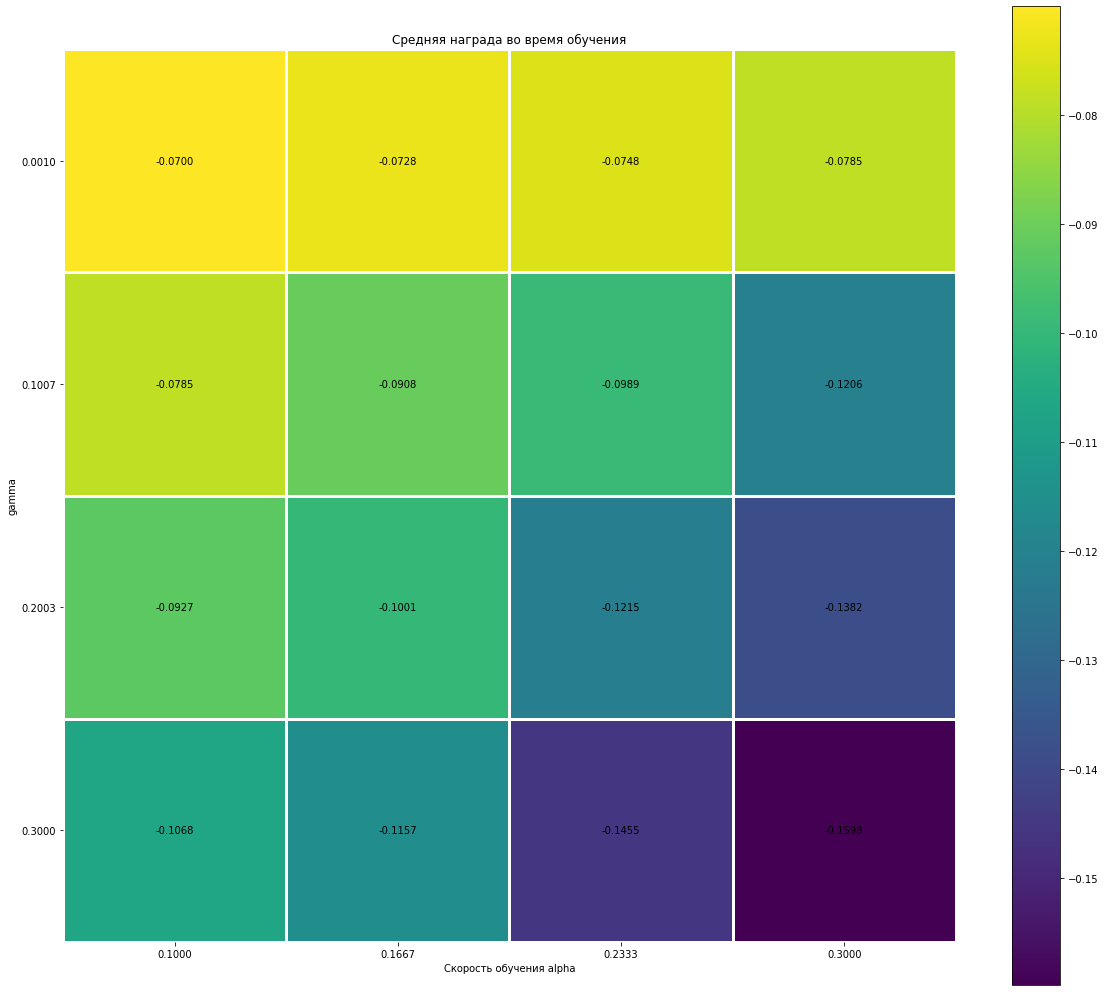

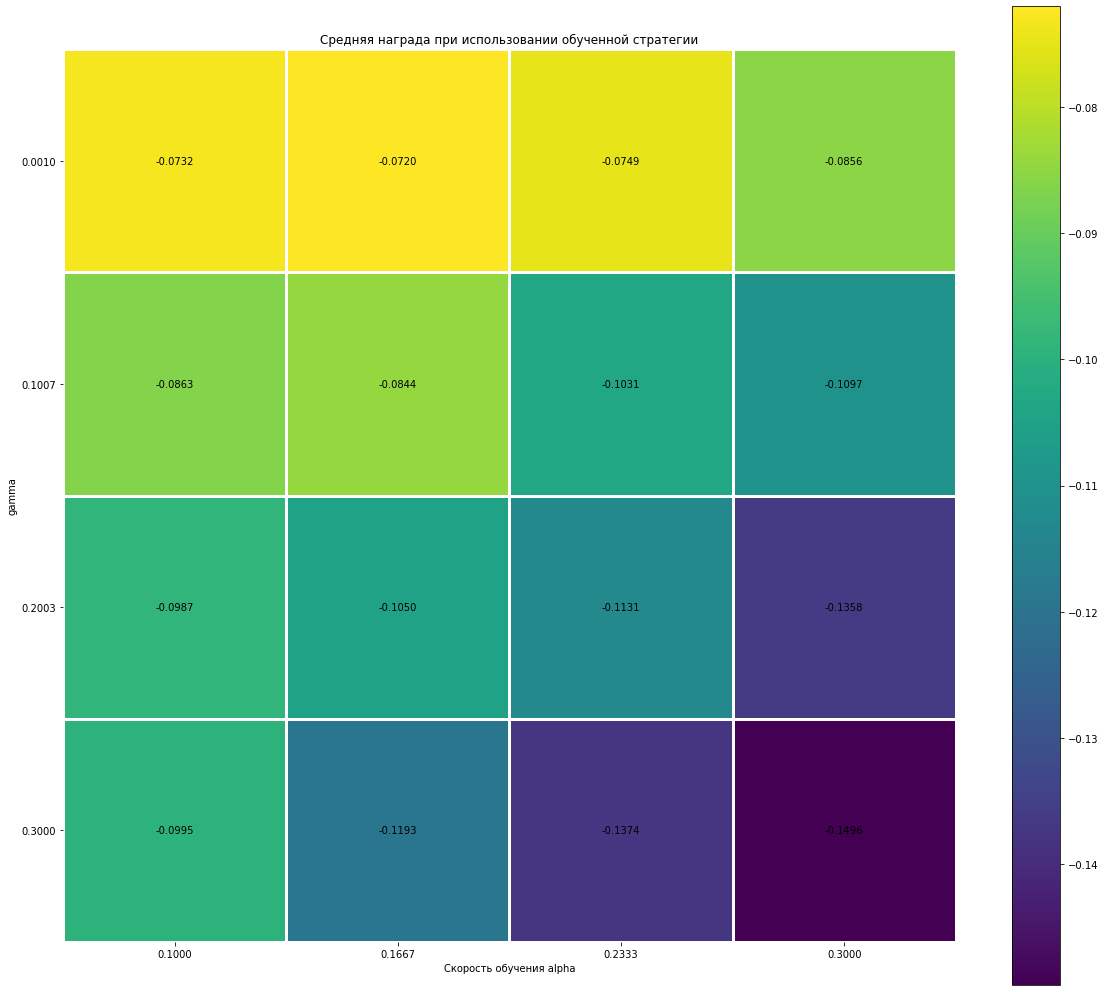

In [13]:
plot_stat(alpha_values, gama_values, train_stat, test_stat);

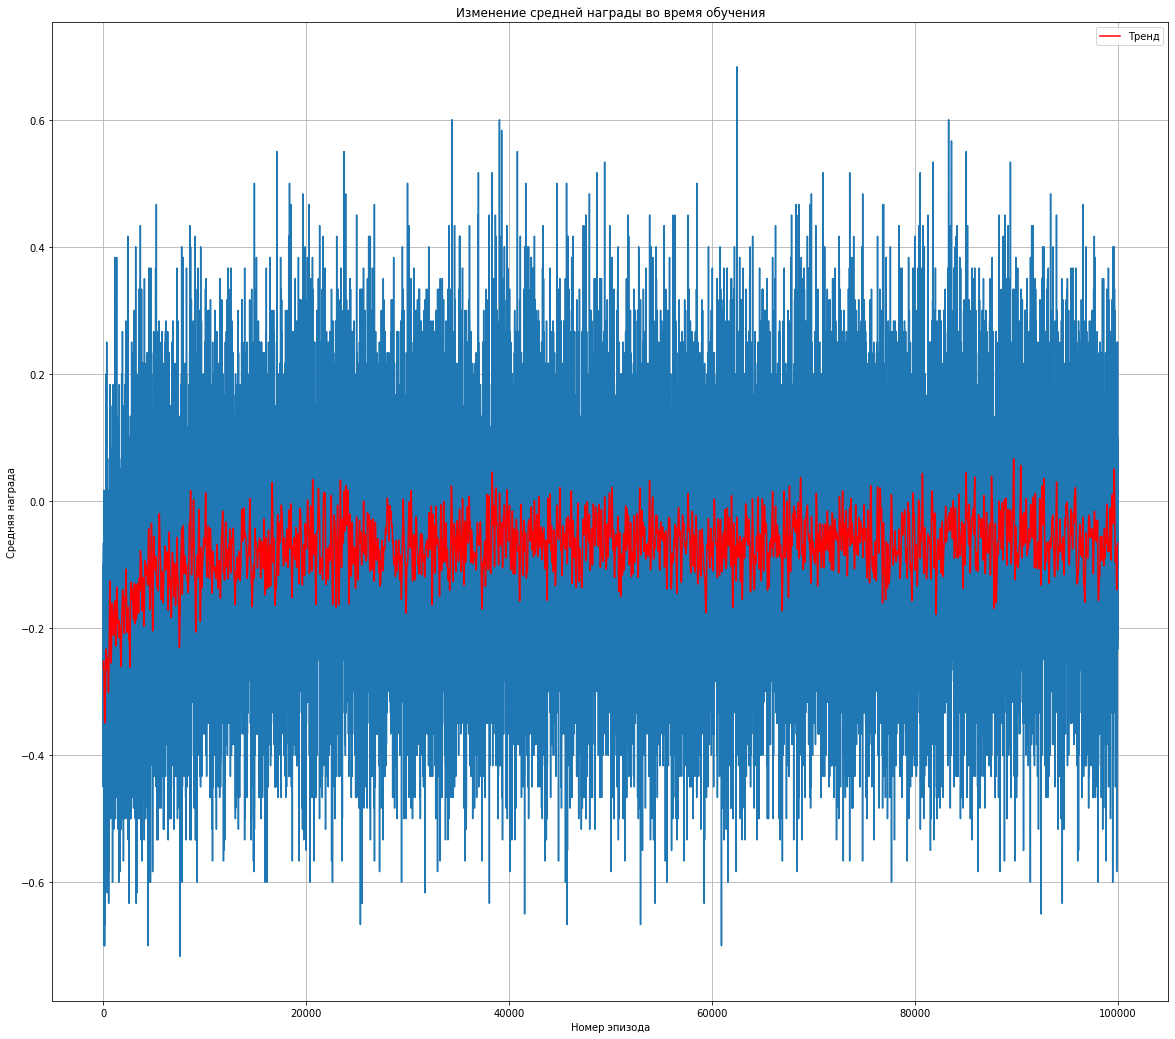

In [14]:
plot_training_process(training_process.test_episodes, training_process.test_mean_rewards);

## Sarsa

In [15]:
train_stat, test_stat, training_process, final_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values, epsilon=epsilon, num_train_episodes=num_train_episodes,
    num_test_episodes=num_test_episodes, learning_cls=Sarsa, env=env, num_train_episodes_on_best_params=num_train_episodes_on_best)
states["base"]["sarsa"] = final_stat

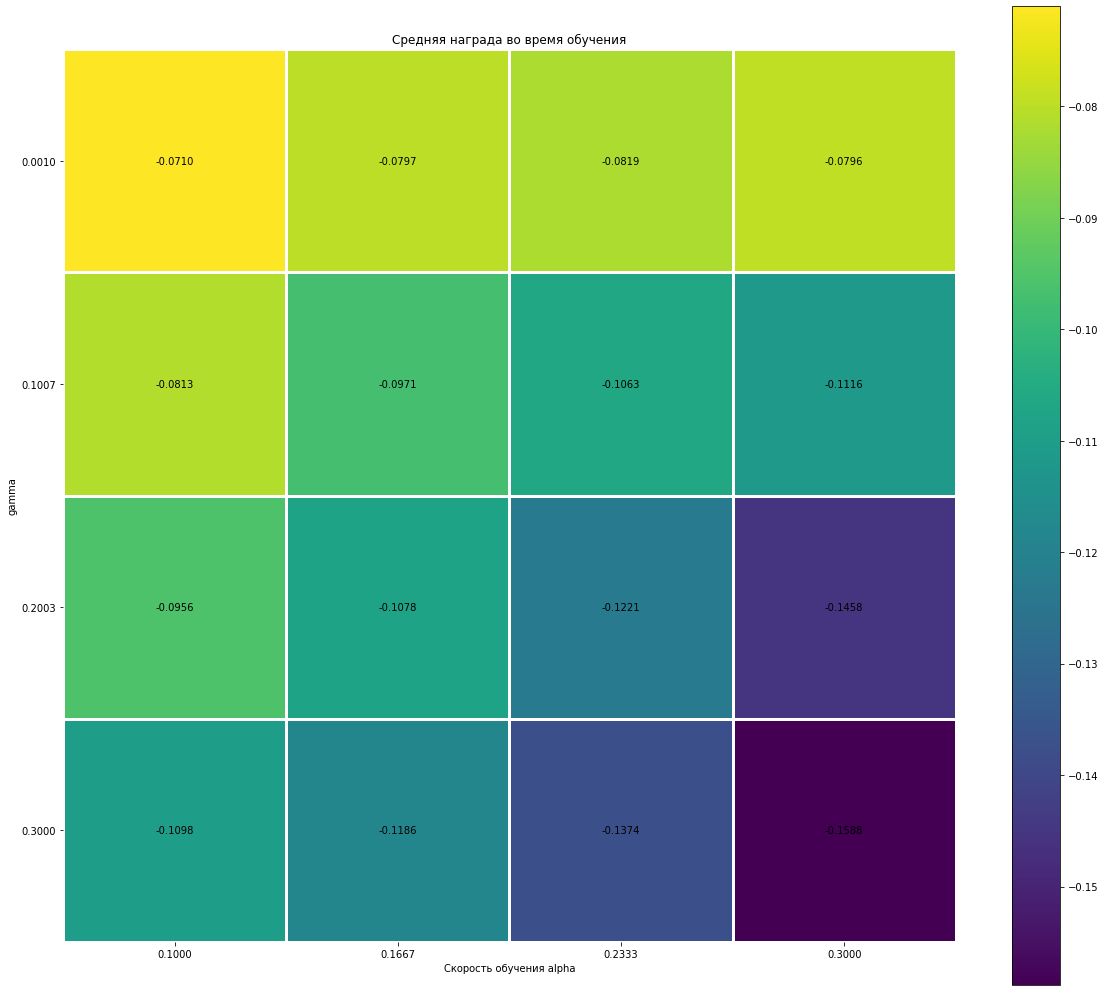

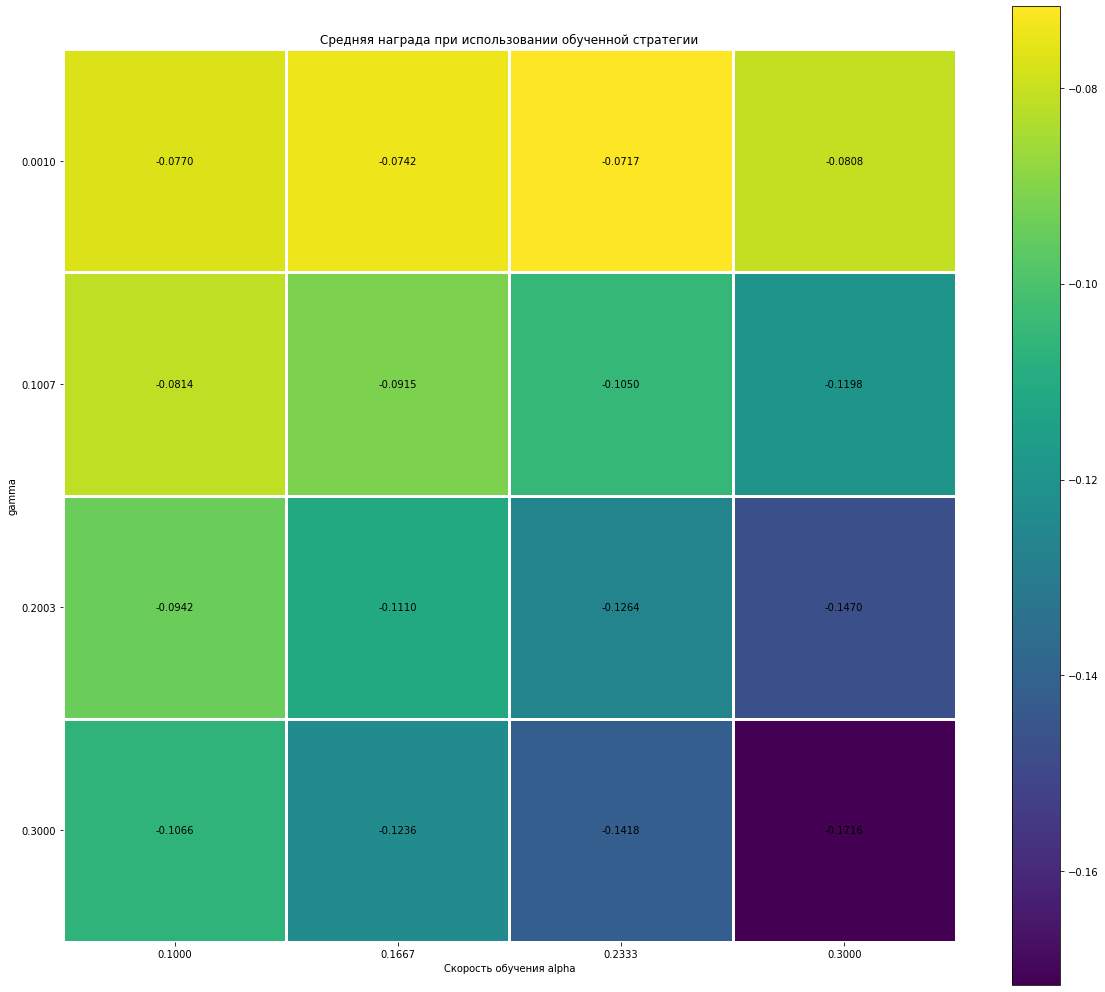

In [16]:
plot_stat(alpha_values, gama_values, train_stat, test_stat);

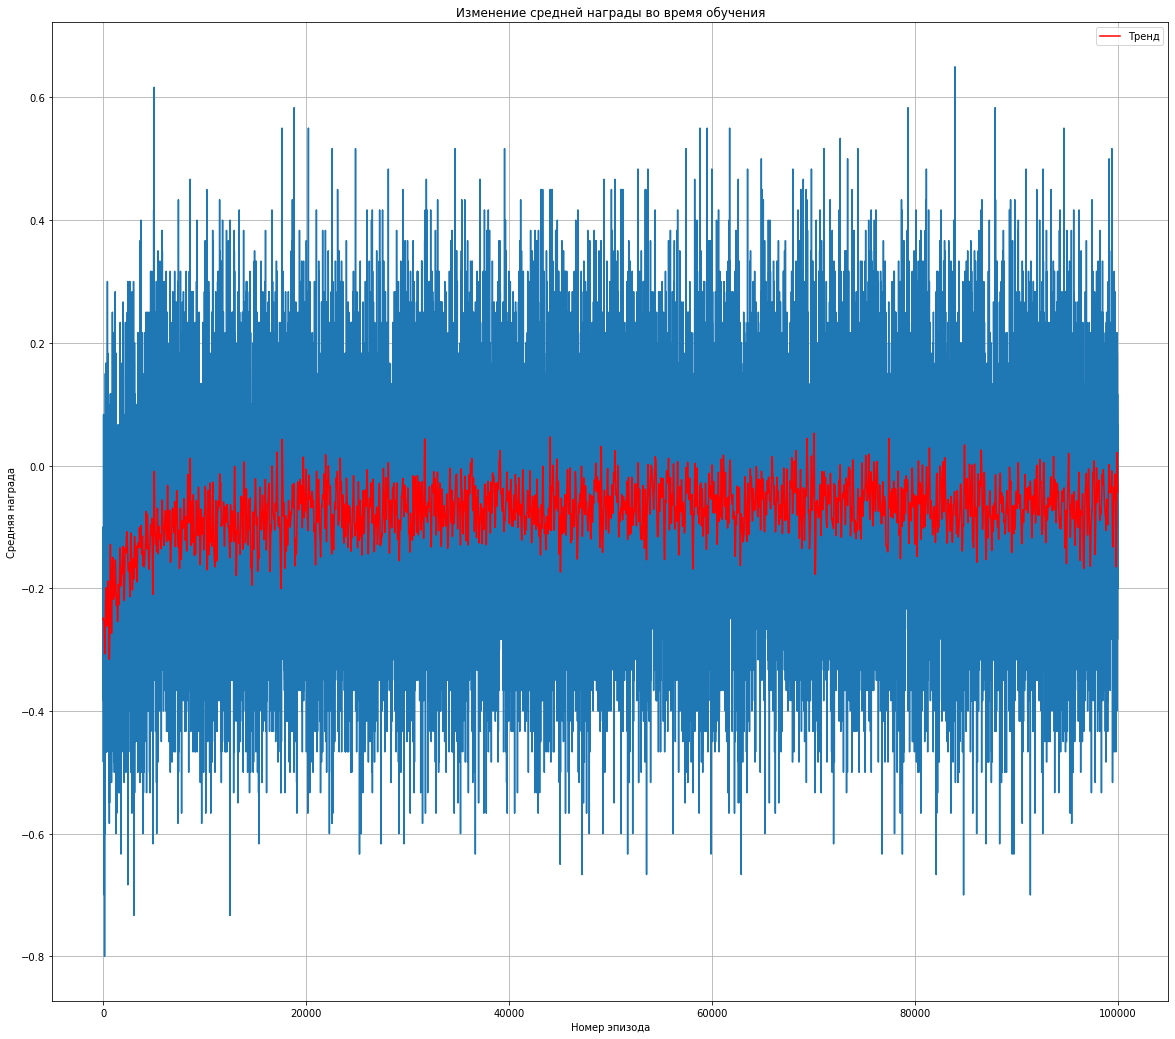

In [17]:
plot_training_process(training_process.test_episodes, training_process.test_mean_rewards);

# Часть вторая (окружение с удвоением ставки)

In [18]:
num_train_episodes_on_best = 400_000

In [19]:
env = BlackjackEnvDouble(natural=True, seed=get_seed())

## Q-обучение

In [20]:
train_stat, test_stat, training_process, final_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values,
    epsilon=epsilon, num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes, 
    env=env, action_space=ExtendedAction, num_train_episodes_on_best_params=num_train_episodes_on_best)
states["double"]["q"] = final_stat

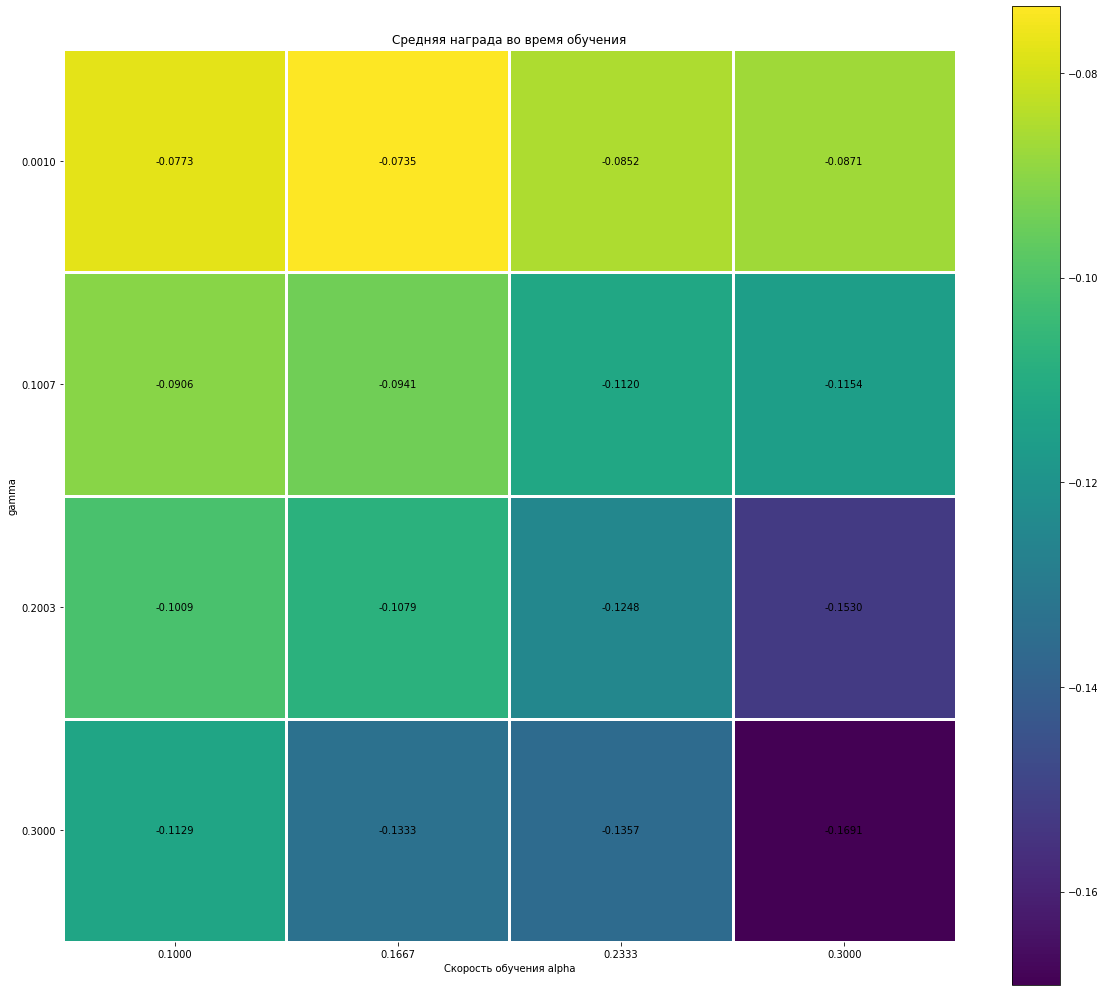

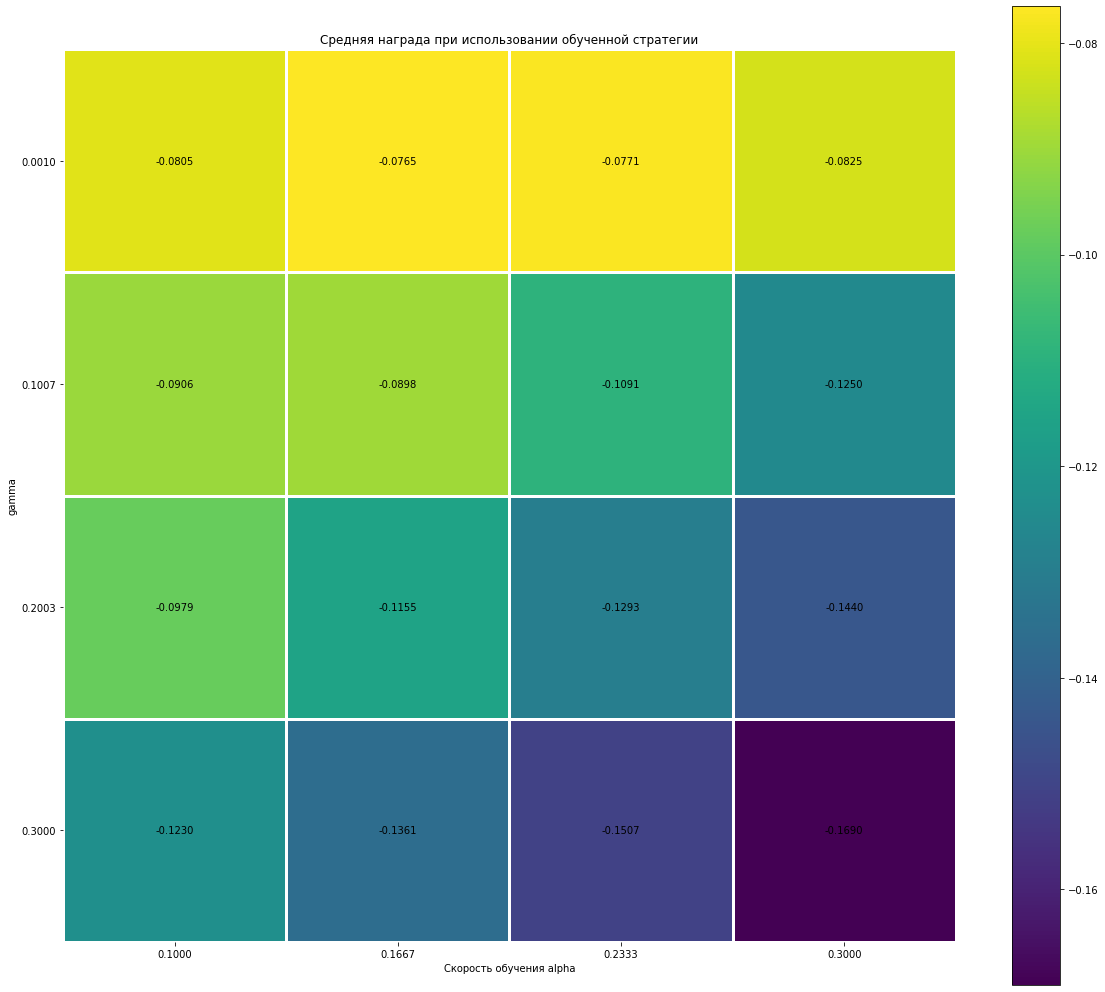

In [21]:
plot_stat(alpha_values, gama_values, train_stat, test_stat);

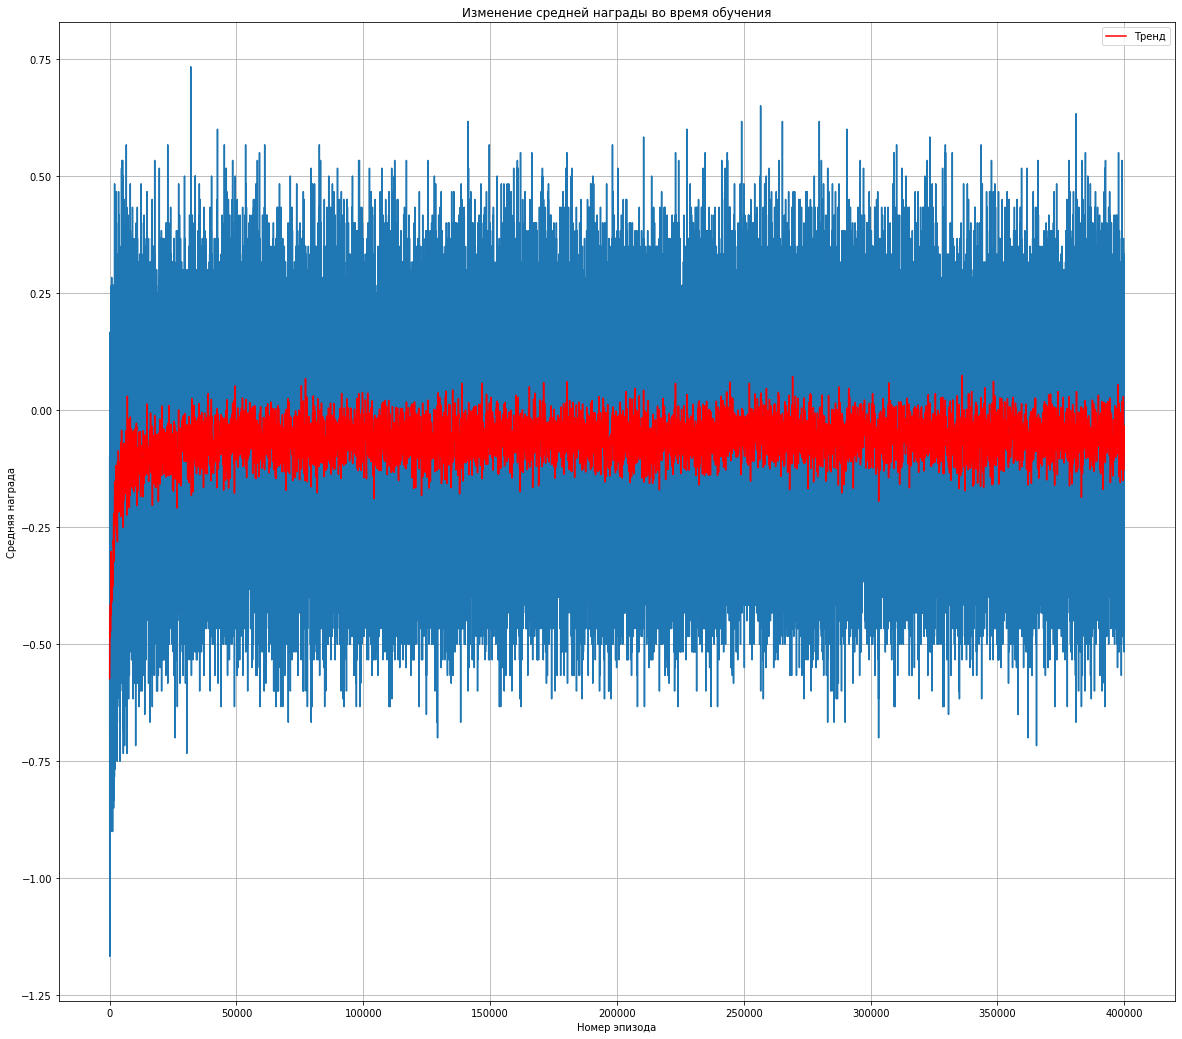

In [22]:
plot_training_process(training_process.test_episodes, training_process.test_mean_rewards);

## Sarsa

In [23]:
train_stat, test_stat, training_process, final_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values, epsilon=epsilon, num_train_episodes=num_train_episodes,
    num_test_episodes=num_test_episodes, learning_cls=Sarsa, env=env, action_space=ExtendedAction, num_train_episodes_on_best_params=num_train_episodes_on_best)
states["double"]["sarsa"] = final_stat


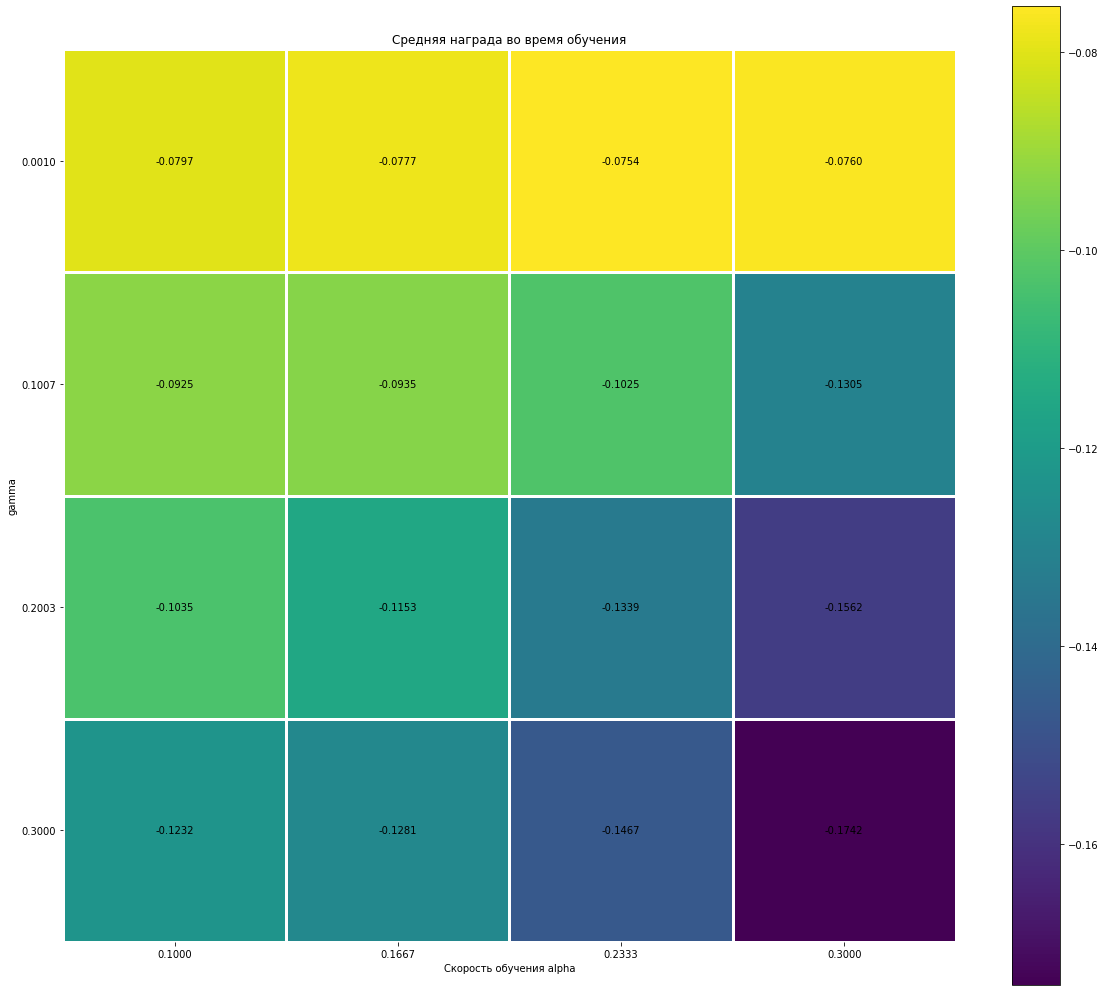

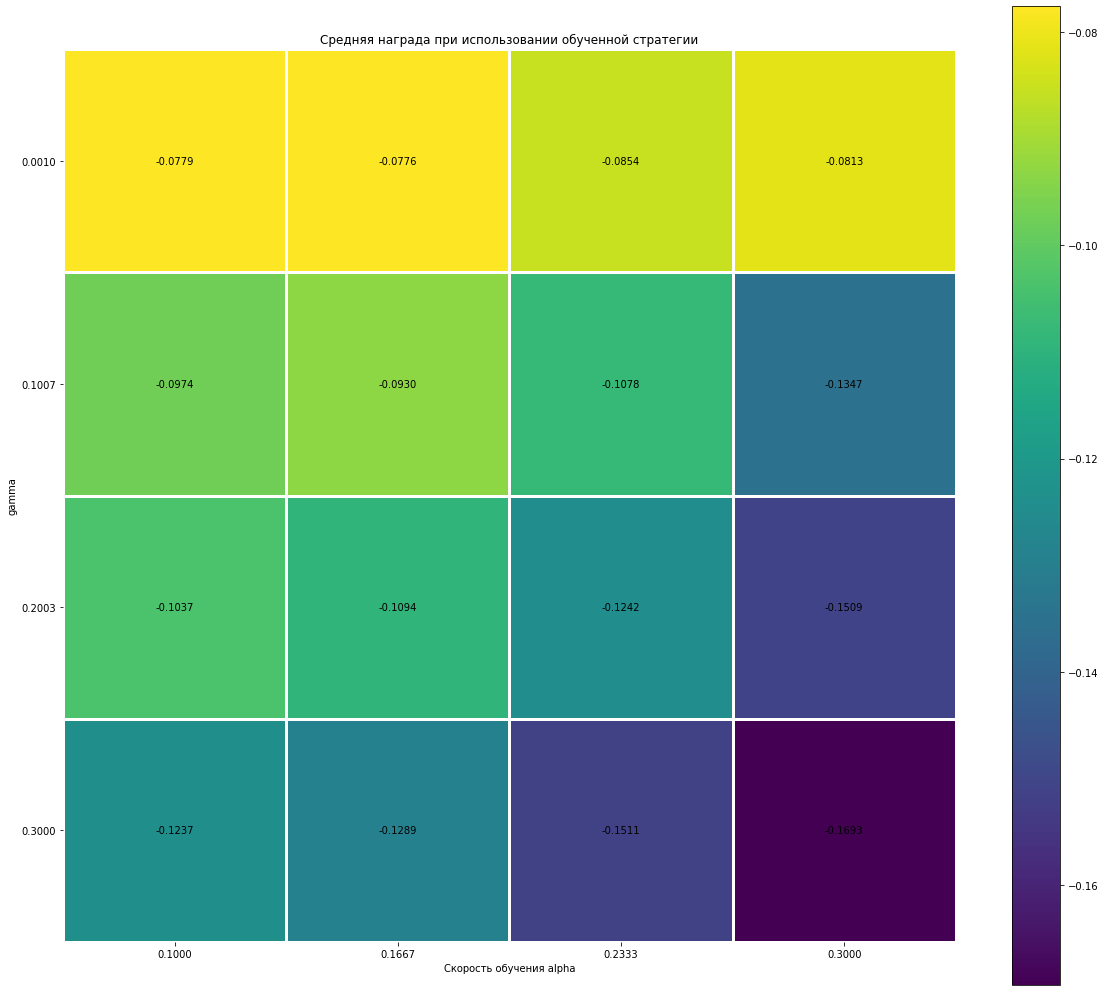

In [24]:
plot_stat(alpha_values, gama_values, train_stat, test_stat);

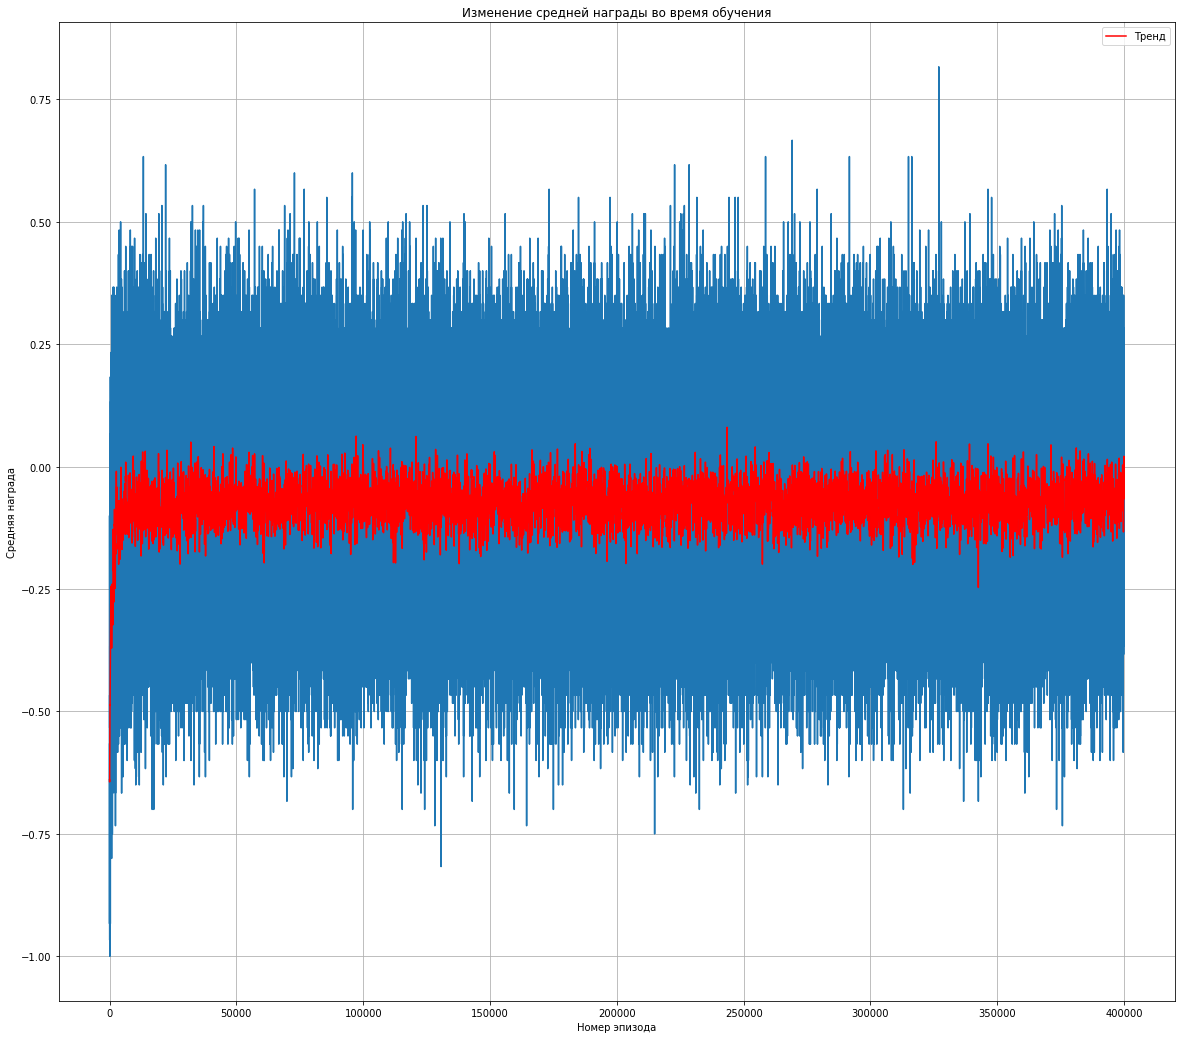

In [25]:
plot_training_process(training_process.test_episodes, training_process.test_mean_rewards);

# Часть третья (окружение с подсчётом карт и удвоением ставки) 

In [26]:
min_cards_before_shuffle = 15
num_train_episodes_on_best = 700_000

env = BlackjackWithShuffle(seed=get_seed(), min_decks_before_shuffle=min_cards_before_shuffle, natural=True)

## Q-обучение

In [27]:
train_stat, test_stat, training_process, final_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values,
    epsilon=epsilon, num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes, 
    env=env, action_space=ExtendedAction, num_train_episodes_on_best_params=num_train_episodes_on_best)
states["counting"]["q"] = final_stat

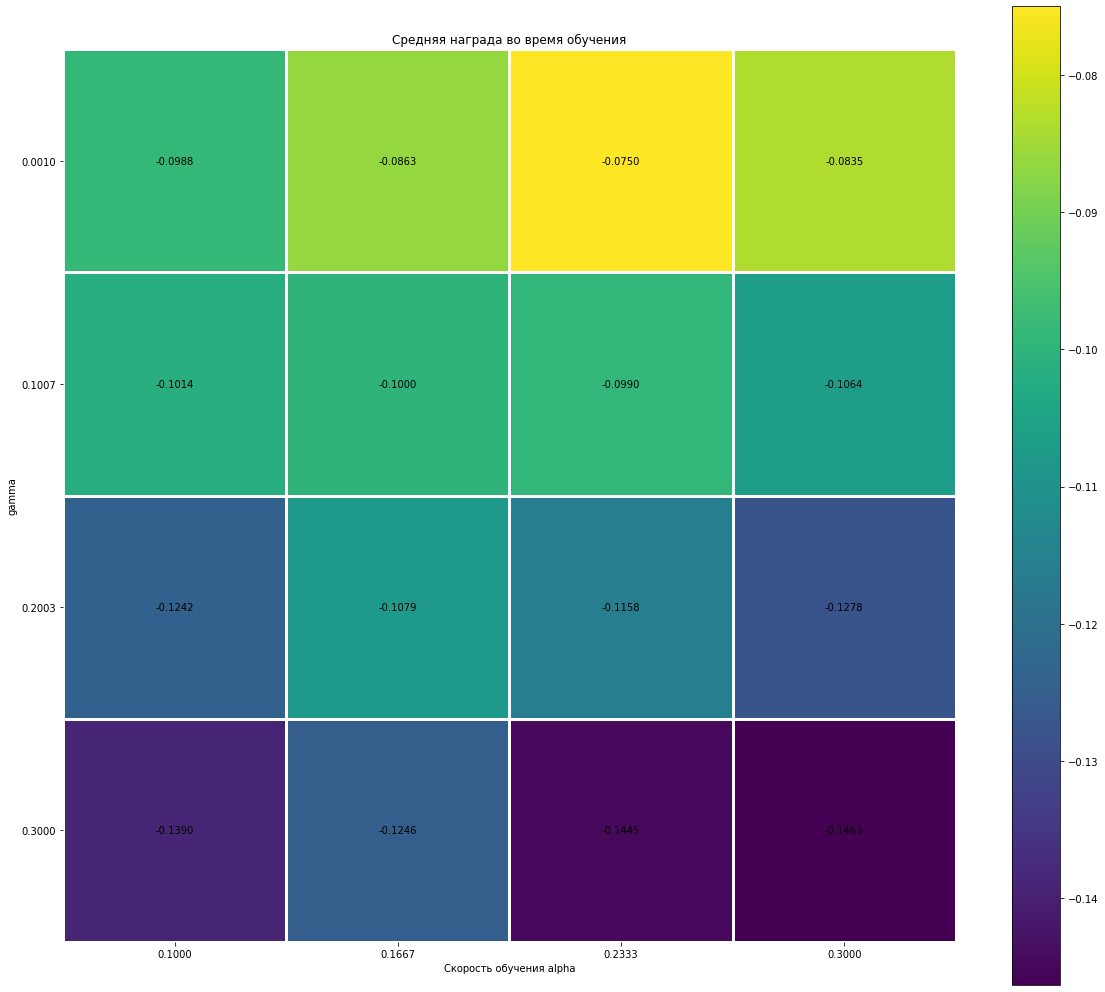

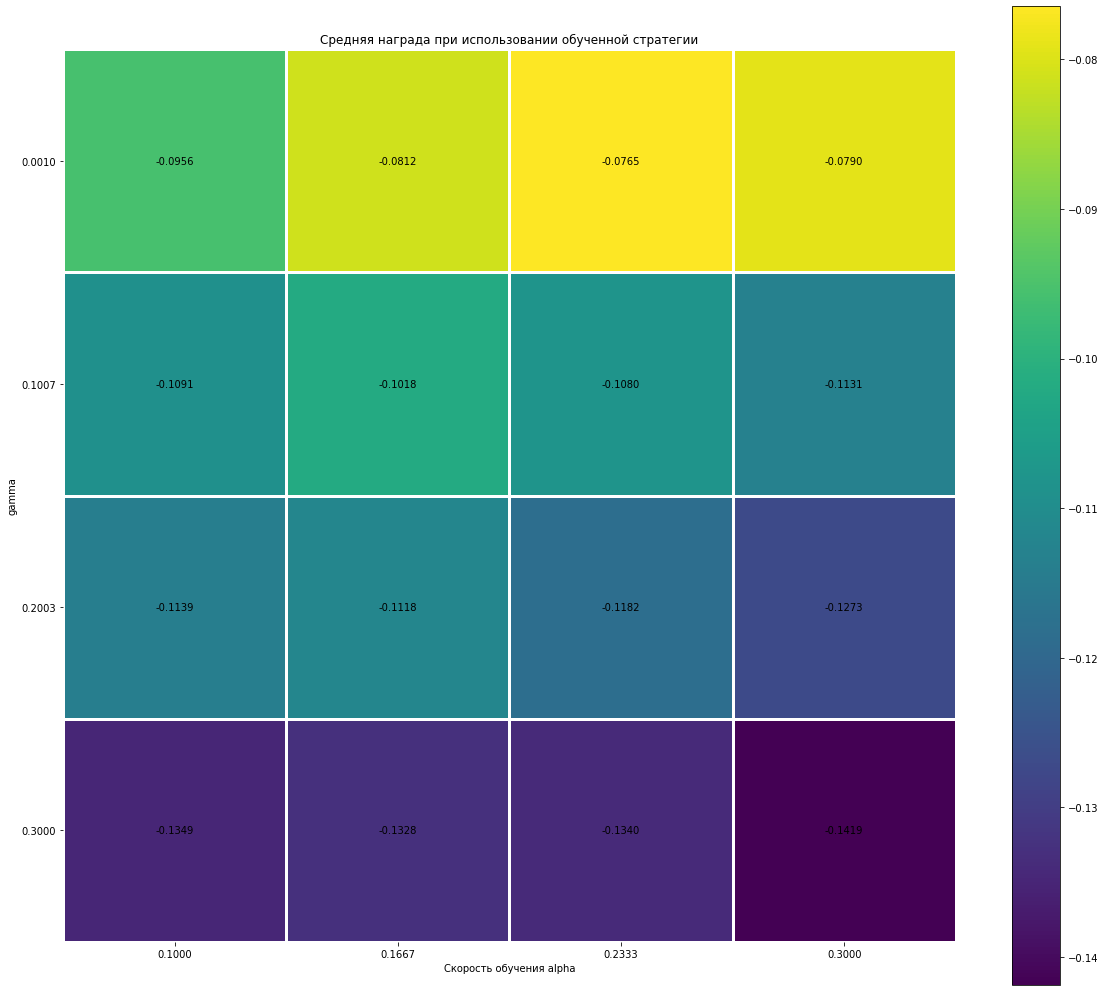

In [28]:
plot_stat(alpha_values, gama_values, train_stat, test_stat);

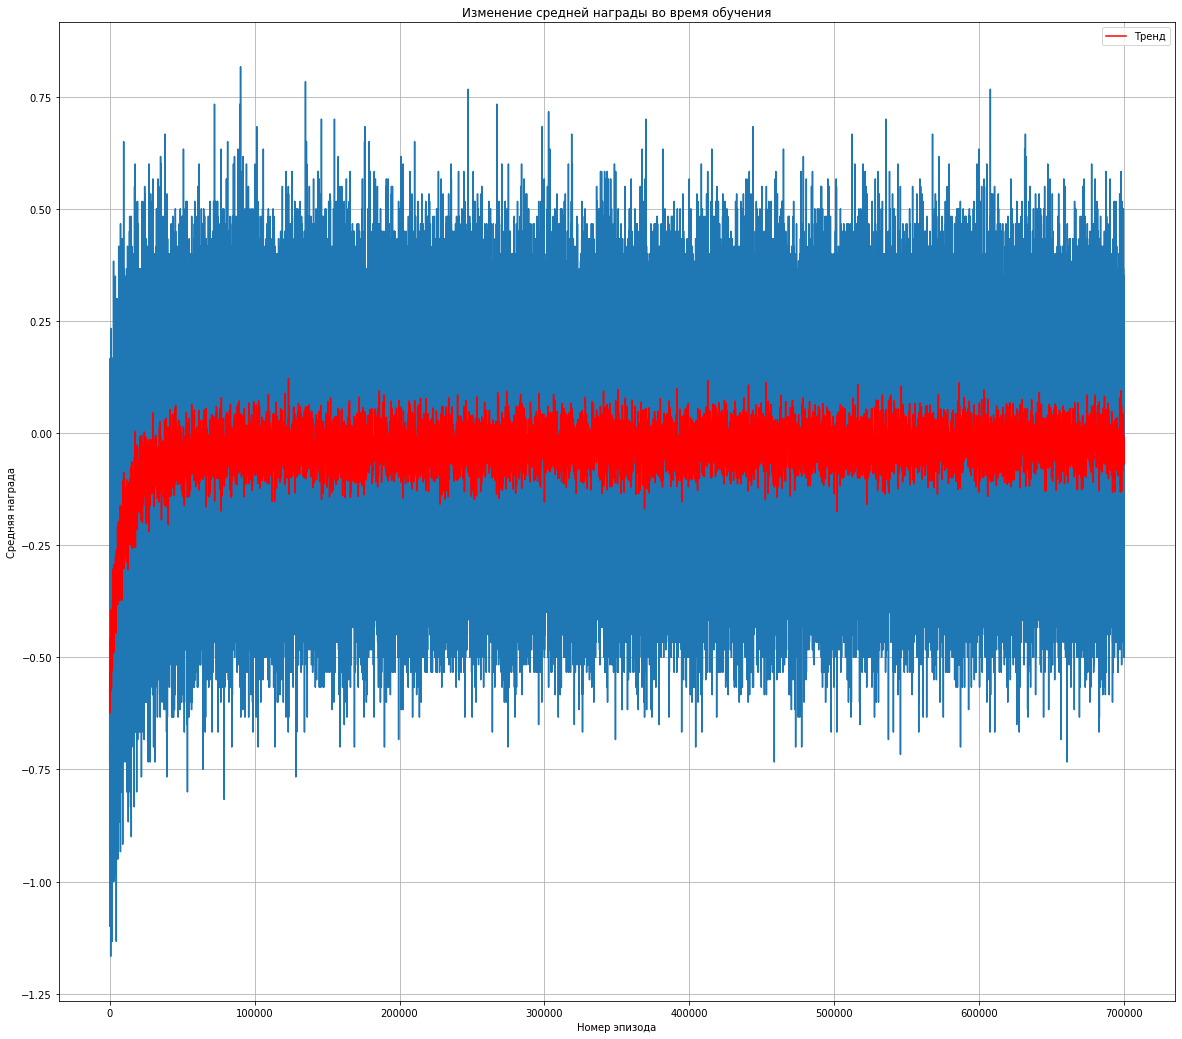

In [29]:
plot_training_process(training_process.test_episodes, training_process.test_mean_rewards);

## Sarsa

In [30]:
train_stat, test_stat, training_process, final_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values,
    epsilon=epsilon, num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes, 
    env=env, action_space=ExtendedAction, learning_cls=Sarsa, num_train_episodes_on_best_params=num_train_episodes_on_best)
states["counting"]["sarsa"] = final_stat

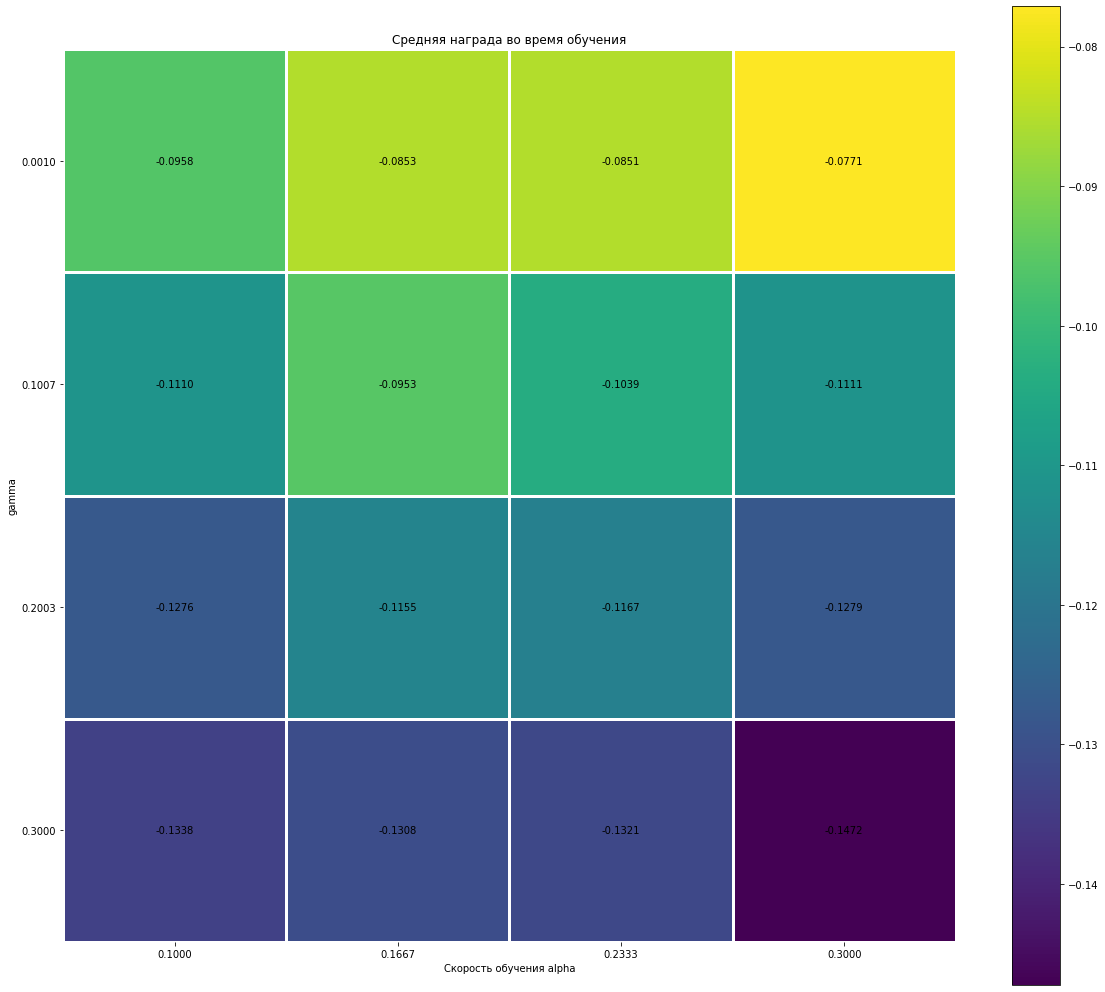

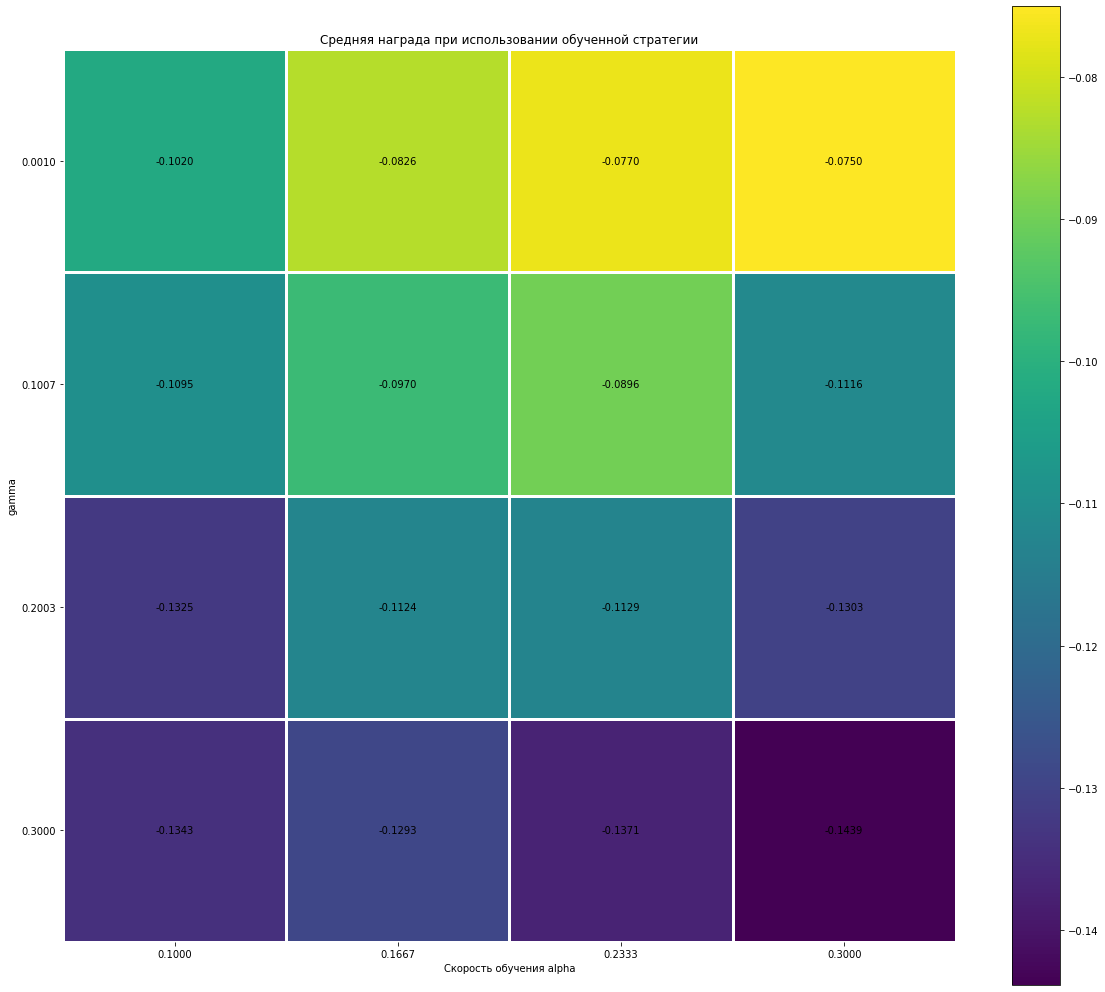

In [31]:
plot_stat(alpha_values, gama_values, train_stat, test_stat);

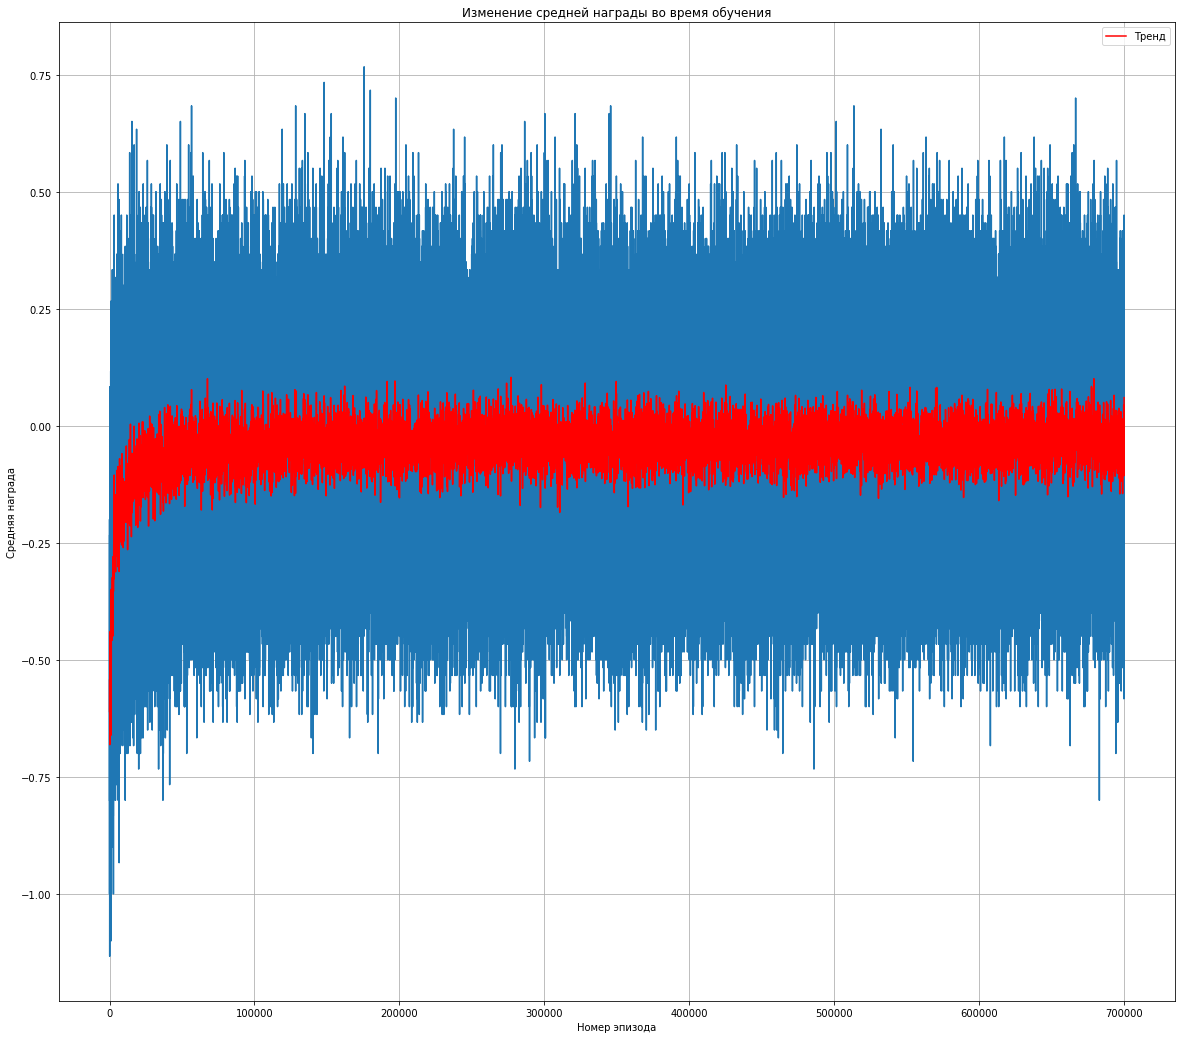

In [32]:
plot_training_process(training_process.test_episodes, training_process.test_mean_rewards);

# Сравнение моделей и алгоритмов 

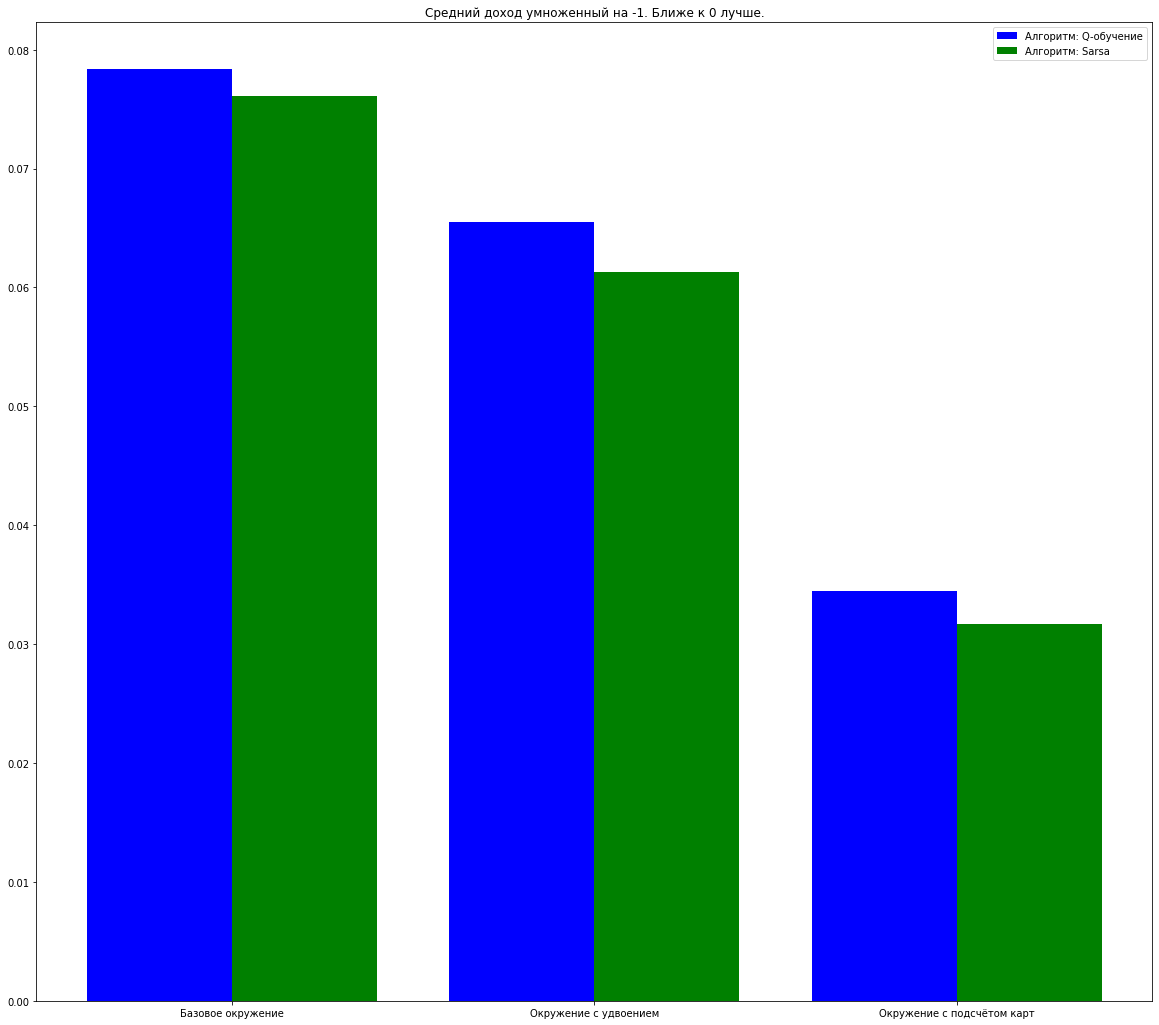

In [33]:
plot_final_stat(states);